# Generalization

## Introduction

In this notebook, we evaluate the generalization of the best model identified in the previous notebook. We will assess any limitations and suggest approaches to address them. Before we proceed, let's review the improvements made throughout the experiments.

## Improvements per Experiment

We conducted a series of experiments to optimize the prediction of leaf type mixture in the study area. The following improvements were made:

1. **Band Importance:** Using recursive feature elimination (RFE) with a random forest model, we identified significant bands and indices.
2. **Compositing:** We determined the optimal number of composites per compositing method and year to refine the dataset.
3. **Hyperparameter Tuning:** We optimized hyperparameters for multiple regression models and selected the best model based on performance.

We compute the RMSE values after each experiment, as well as before all experiments together with a dummy model for estimating the upper bound to evaluate the improvements:

In [1]:
# Compute the RMSEs throughout the experiments
import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from tqdm.notebook import tqdm

from ltm.features import load_raster
from ltm.models import bands_from_importance


def compute_rmse(model, data, target):
    scoring = "neg_root_mean_squared_error"
    cv_scores = cross_val_score(model, data, target, scoring=scoring, n_jobs=-1)
    return -cv_scores.mean()


report_path = "../reports/generalization.csv"

if not Path(report_path).exists():
    # Load the data from the experiments
    experiment_paths = [
        "../data/processed/ground_truth/data_2A.tif",
        "../data/processed/band_importance/data.tif",
        "../data/processed/data.tif",
    ]
    experiments = [load_raster(path) for path in experiment_paths]

    # Use only the selected bands from the band importance experiment
    sentinel_bands, index_bands = bands_from_importance(
        "../reports/band_importance.csv"
    )
    bands = [f"1 {band} mean" for band in sentinel_bands + index_bands]
    experiments[1] = experiments[1][bands]

    # Load the target raster
    target_path = "../data/processed/target.tif"
    target = load_raster(target_path)

    # Apply the target mask
    mask = target.notna()
    experiments = [experiment[mask] for experiment in experiments]
    target = target[mask]

    # Compute the RMSE for each experiment as well as for a dummy regressor
    rf = RandomForestRegressor(n_jobs=-1, random_state=42)
    rmse_scores = []
    for experiment in tqdm(experiments):
        rmse_scores.append(compute_rmse(rf, experiment, target))
    ht_df = pd.read_csv("../reports/hyperparameter_tuning.csv")
    rmse_scores.append(ht_df["Root Mean Squared Error"].min())
    dummy = DummyRegressor()
    rmse_dummy = compute_rmse(dummy, target, target)

    df = pd.DataFrame(
        {
            "Experiment": [
                "Dummy Regressor",
                "Baseline",
                "Band Importance",
                "Compositing",
                "Hyperparameter Tuning",
            ],
            "Root Mean Squared Error": [rmse_dummy] + rmse_scores,
        }
    )

    df.to_csv(report_path, index=False)
else:
    df = pd.read_csv(report_path)

max_chars = max(df["Experiment"].map(len))
for experiment, rmse in zip(df["Experiment"], df["Root Mean Squared Error"]):
    print(f"{experiment + ':':<{max_chars + 1}} {rmse:.3f} RMSE")

Dummy Regressor:       0.456 RMSE
Baseline:              0.306 RMSE
Band Importance:       0.279 RMSE
Compositing:           0.260 RMSE
Hyperparameter Tuning: 0.250 RMSE


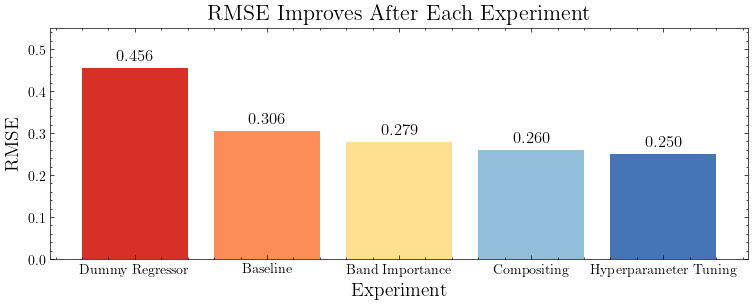

In [2]:
# Bar plot of RMSE across all experiments
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

# Data for plotting
methods = df["Experiment"]
rmse_values = df["Root Mean Squared Error"]

# Colors for each bar
colors = ["#d73027", "#fc8d59", "#fee090", "#91bfdb", "#4575b4"]

# Create the plot
fig, ax = plt.subplots(figsize=(9, 3))
bars = ax.bar(methods, rmse_values, color=colors)

# Adding titles and labels
ax.set_title("RMSE Improves After Each Experiment", fontsize=16, weight="bold")
ax.set_xlabel("Experiment", fontsize=14)
ax.set_ylabel("RMSE", fontsize=14)
ax.set_ylim(0, 0.55)

# Adding text annotations on top of the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.3f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset
        textcoords="offset points",
        ha="center",
        va="bottom",
        fontsize=12,
    )

figure_path = f"../reports/figures/generalization/{ax.get_title()}.svg"
Path(figure_path).parent.mkdir(parents=True, exist_ok=True)
plt.savefig(figure_path, dpi=300)

We observed a decrease in RMSE values with each experiment, most significantly after the first experiment and least after the last one. This saturation suggests we are close to the optimal model. The distance in RMSE to the uninformed model increased from 0.15 to 0.206. The best model, determined in the last experiment, achieved an RMSE of 0.250.

## Generalization of the Best Model

To evaluate the generalization capabilities of the best model, we apply it to an unseen area. We choose a large, coherent region of the "Freisinger Forst" (Freising Forest) in Bavaria, Germany, covering approximately 6.2 square kilometers. This area is located about 90 kilometers from the original study site. The Freising Forest features a mix of coniferous and deciduous trees, varying levels of heterogeneity, and a wide range of age groups. These diverse conditions are crucial for testing the model's generalization. We perform the inference starting from a shapefile of the area, creating the composites in the same manner as those for the study area:

In [3]:
# Create empty target raster from shape with NaNs outside of shape
from ltm.data import shapefile2raster

name = "Freisinger Forst"
shapefile_path = f"../data/raw/{name}/{name}.shp"
prediction_path = f"../data/processed/generalization/{name}.tif"
year = 2018
batch_size = 25  # TODO: remove: 25 for Freisinger Forst, 100 for Peterfecking, 200 for Traunstein, None for Brunnstube

Path(prediction_path).parent.mkdir(parents=True, exist_ok=True)
if not Path(prediction_path).exists():
    shapefile2raster(
        shapefile_path=shapefile_path,
        raster_path=prediction_path,
    )

In [4]:
# Create data for the target area
from ltm.models import create_data

stem = Path(prediction_path).stem
data_folder = str(Path(prediction_path).parent / stem)
create_data(year, prediction_path, data_folder, batch_size=batch_size)

In [5]:
# Load best model from hyperparameter tuning
import dill

df = pd.read_csv("../reports/hyperparameter_tuning.csv", index_col=0)
best_model = df["Root Mean Squared Error"].idxmin()

with open(f"../models/{best_model}.pkl", "rb") as f:
    best_model = dill.load(f)

In [6]:
# Predict on new data with the best model
import rasterio


def predict_on(data_path, prediction_path, model):
    data = load_raster(data_path)
    prediction = model.predict(data)

    # Read profile and raster params
    with rasterio.open(prediction_path) as src:
        profile = src.profile
        shape = src.read().shape
        nan_mask = np.isnan(src.read())

    # Write prediction to target raster
    with rasterio.open(prediction_path, "w", **profile) as dst:
        reshaped = prediction.reshape(shape)
        reshaped[nan_mask] = np.nan
        dst.write(reshaped)
        dst.descriptions = ("Conifer Proportion",)


data_path = f"{data_folder}/{year}/data.tif"
data = load_raster(data_path)
predict_on(data_path, prediction_path, best_model)

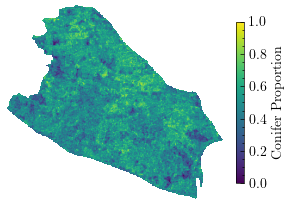

In [7]:
# Plot the prediction
import matplotlib as mpl
from rasterio.plot import show

# Prepare the colormap
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

with rasterio.open(prediction_path) as src:
    raster = src.read()

    # Create subplot and colorbar
    fig, ax = plt.subplots()
    fig.colorbar(mappable, ax=ax, label="Conifer Proportion", shrink=0.8)
    ax.axis("off")

    show(raster, ax=ax, cmap=cmap, norm=norm)

figure_path = f"../reports/figures/generalization/Best Model.svg"
plt.savefig(figure_path, dpi=300)

It is immediately noticeable that the prediction covers only a small range of conifer proportions, showing little variation and structure. This suggests overfitting. Without ground truth data for this area, we cannot directly evaluate the prediction. However, we can compare it to the Dominant Leaf Type (DLT) 2018 map, which classifies the pixels as either broadleaf or conifer:

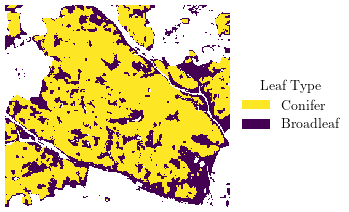

In [8]:
# Download dominant leaf type (DLT) 2018
from ltm.data import download_dlt_2018
from matplotlib.patches import Patch

dlt_path = f"{data_folder}/{year}/dominant_leaf_type.tif"
download_dlt_2018("../data/processed/generalization/Freisinger Forst.tif", dlt_path)

with rasterio.open(dlt_path) as src:
    ax = plt.subplot()
    ax = show(src, interpolation="nearest", cmap=cmap, norm=norm, ax=ax)
    ax.axis("off")

ax.legend(
    handles=[
        Patch(facecolor=cmap.get_over(), label="Conifer"),
        Patch(facecolor=cmap.get_under(), label="Broadleaf"),
    ],
    title="Leaf Type",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)

figure_path = f"../reports/figures/generalization/DLT 2018.svg"
plt.savefig(figure_path, dpi=300)

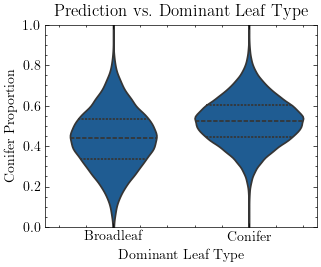

In [9]:
# Compare prediction with DLT
import seaborn as sns
from ltm.features import load_raster

dominant_leaf_type = load_raster(dlt_path)
prediction = load_raster("../data/processed/generalization/Freisinger Forst.tif")

mask = prediction.notna() & dominant_leaf_type.notna()
dominant_leaf_type = dominant_leaf_type[mask]
prediction = prediction[mask]

ax = sns.violinplot(x=dominant_leaf_type, y=prediction, inner="quart")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Broadleaf", "Conifer"])
ax.set_xlabel("Dominant Leaf Type")
ax.set_title("Prediction vs. Dominant Leaf Type")
ax.set_ylim(0, 1)

figure_path = f"../reports/figures/generalization/Best Model Prediction vs. DLT.svg"
plt.savefig(figure_path, dpi=300)

This violin plot supports the observation that the model is overfitting. The difference between conifer and broadleaf is minimal, displaying a similar distribution regardless of leaf type. Additionally, the predictions center around a conifer proportion of 0.5, suggesting a predominantly homogeneous leaf type mixture.

To test the theory of overfitting, we try a simple approach, as our experiments may have led to excessive overfitting to the study area and the conditions present from April 1, 2017, to March 31, 2018. If the simple approach performs significantly better, we may have over-optimized for high predictive ability in the study area, hindering generalization to other areas.

## Generalization of a Simple Approach

Our simple approach uses a Random Forest regressor trained on a one-year average composite starting April 1, 2017. We utilize all Level-2A bands beginning with "B" (B1 to B12) to focus solely on the spectral bands. We predict on the Freising Forest using this simpler model and data:

In [10]:
# Create train and test data rasters
from ltm.data import sentinel_composite
from datetime import datetime
from ltm.data import list_bands

bands = list_bands()
bands = [b for b in bands if b.startswith("B")]

data_path = "../data/processed/generalization/simple/data.tif"
test_path = "../data/processed/generalization/simple/Freisinger Forst.tif"

Path(data_path).parent.mkdir(parents=True, exist_ok=True)
if not Path(data_path).exists():
    sentinel_composite(
        target_path_from="../data/processed/target.tif",
        data_path_to=data_path,
        time_window=(datetime(2017, 4, 1), datetime(2018, 4, 1)),
        sentinel_bands=bands,
    )

if not Path(test_path).exists():
    sentinel_composite(
        target_path_from=prediction_path,
        data_path_to=test_path,
        time_window=(datetime(2018, 4, 1), datetime(2019, 4, 1)),
        sentinel_bands=bands,
    )

Initializing Earth Engine API...


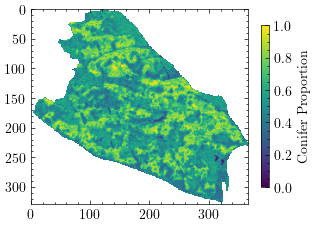

In [11]:
# Predict and show the result
data = load_raster(data_path)
target = load_raster("../data/processed/target.tif")

mask = target.notna()
data = data[mask]
target = target[mask]

model = RandomForestRegressor(n_jobs=-1, random_state=42)
model.fit(data, target)

predict_on(test_path, prediction_path, model)

with rasterio.open(prediction_path) as src:
    raster = src.read()

    # Create subplot and colorbar
    fig, ax = plt.subplots()
    fig.colorbar(mappable, ax=ax, label="Conifer Proportion", shrink=0.8)

    fig = show(raster, ax=ax, cmap=cmap, norm=norm)

figure_path = f"../reports/figures/generalization/Simple Model.svg"
plt.savefig(figure_path, dpi=300)

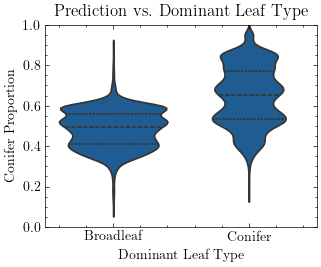

In [12]:
# Compare prediction with DLT
dominant_leaf_type = load_raster(dlt_path)
prediction = load_raster(prediction_path)

mask = prediction.notna() & dominant_leaf_type.notna()
dominant_leaf_type = dominant_leaf_type[mask]
prediction = prediction[mask]

ax = sns.violinplot(x=dominant_leaf_type, y=prediction, inner="quart")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Broadleaf", "Conifer"])
ax.set_xlabel("Dominant Leaf Type")
ax.set_title("Prediction vs. Dominant Leaf Type")
ax.set_ylim(0, 1)

figure_path = f"../reports/figures/generalization/Simple Model Prediction vs. DLT.svg"
plt.savefig(figure_path, dpi=300)

The simple approach results in slightly better discrimination between deciduous and coniferous trees, but the overall prediction quality remains suboptimal. There are almost no predictions with a conifer proportion of 0.3 and below. Since this naive approach leads to overfitting, we conclude that the poor generalization ability observed is likely due to external factors, namely interannual differences and regional variations.

The only theory that remains is that our approach may have resulted in a more complex approach that is prone to overfitting. However, because of this higher degree of flexibility, it may likely perform well when the data is sufficient. To test this theory, we need to use sufficient data.

## Generalization using Multiple Years

To improve the predictions, we will train the model with data from 2017, 2019, and 2020 and use this as a form of data augmentation to enable generalization across multiple years. It is important to note that we are not training the model with data from 2018 as we want to ensure that there is no leakage of the test data conditions into the training data. This might be possible due to the geographical proximity of the study area and the Freising Forest. However, this proximity is most likely representative of actual conditions when the leaf type mixture prediction methodology is applied in practice on a larger scale. The areas for which predictions are made are most likely geographically close to the areas for which the model was trained on.

We predict on the Freising Forest with this new approach:

In [13]:
# Create data for 2017, 2019, and 2020
target_path = "../data/processed/target.tif"
data_folder = "../data/processed/generalization/data/"
refit_years = [2017, 2019, 2020]

for refit_year in tqdm(refit_years, desc="Years"):
    create_data(refit_year, target_path, data_folder)

# Concatenate all data into one dataframe
print("Combining data...")
total_data = pd.DataFrame()
for refit_year in tqdm(refit_years, desc="Years"):
    stem = Path(data_folder).stem
    data_path = Path(data_folder) / f"{refit_year}/data.tif"
    data = load_raster(str(data_path))
    total_data = pd.concat([total_data, data])

# Create target data
target = load_raster(target_path)
total_target = pd.concat([target] * len(refit_years))

# Drop rows with NaN label
mask = total_target.notna()
data, target = total_data[mask], total_target[mask]

Years:   0%|          | 0/3 [00:00<?, ?it/s]

Combining data...


Years:   0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
# Train best model on new data of the study area
from sklearn.base import clone

refitted_path = f"../models/refitted.pkl"

if not Path(refitted_path).exists():
    # Clone model in case warm_start=True and fit on new data
    refitted = clone(best_model)
    refitted.fit(data, target)

    with open(refitted_path, "wb") as f:
        dill.dump(refitted, f)
else:
    with open(refitted_path, "rb") as f:
        refitted = dill.load(f)

refitted

Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0.02263403330811986,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.04202523026242301, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=3, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=193, n_jobs=-1,
                              num_parallel_tree=None, random_state=42, ...))])

In [15]:
# Predict with new model on the same test data as before
data_path = f"../data/processed/generalization/{name}/{year}/data.tif"
prediction_path = f"../data/processed/generalization/{name}.tif"

predict_on(data_path, prediction_path, refitted)

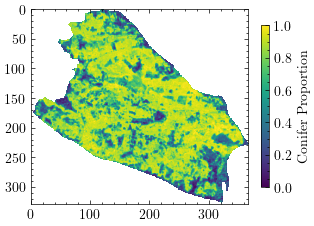

In [16]:
# Plot the prediction
with rasterio.open(prediction_path) as src:
    raster = src.read()

    # Create subplot and colorbar
    fig, ax = plt.subplots()
    fig.colorbar(mappable, ax=ax, label="Conifer Proportion", shrink=0.8)

    fig = show(raster, ax=ax, cmap=cmap, norm=norm)

figure_path = f"../reports/figures/generalization/Refitted Model.svg"
plt.savefig(figure_path, dpi=300)

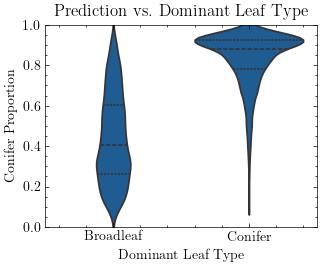

In [17]:
# Compare prediction with DLT
dominant_leaf_type = load_raster(dlt_path)
prediction = load_raster(f"../data/processed/generalization/{name}.tif")

mask = prediction.notna() & dominant_leaf_type.notna()
dominant_leaf_type = dominant_leaf_type[mask]
prediction = prediction[mask]

ax = sns.violinplot(x=dominant_leaf_type, y=prediction, inner="quart")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Broadleaf", "Conifer"])
ax.set_xlabel("Dominant Leaf Type")
ax.set_title("Prediction vs. Dominant Leaf Type")
ax.set_ylim(0, 1)

figure_path = f"../reports/figures/generalization/Refitted Model Prediction vs. DLT.svg"
plt.savefig(figure_path, dpi=300)

The predictions show much better differentiation between broadleafs and conifers, with a more nuanced and balanced distribution. The predictions are more broadly distributed across the deciduous tree class, while the coniferous tree class has most predictions concentrated at a high proportion of conifers. This suggests that the model generalizes better to unseen areas when trained over multiple years. We show that this type of data augmentation is required to generalize effectively. This leads us to believe that differences between years were the main cause of the poor generalization.

## Conclusion

We demonstrate that predicting the leaf type mixture of forests in temperate regions is possible using Sentinel-2 data. We successfully use Recursive Feature Elimination to determine the most important bands and indices, optimize the number of composites per compositing method and year, and select the best regression model with optimized hyperparameters. We highlight the vitality of a diverse and representative dataset for training and the importance of generalizing to unseen areas.

For further research, we recommend using more recent data, which allows the use of years prior to the sample year for training. Our ground truth data was collected before the availability of the first Level-2A images, which restricts this approach. Ideally, an area with a slowly changing composition of leaf type mixture should be used for training, ensuring high-quality ground truth data for every given year. Additionally, artificial data augmentation might be employed to increase the amount of training data.